<a href="https://colab.research.google.com/github/KimJisanER/Dacon/blob/main/22_01_29_Dacon_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# !pip install catboost
# !pip install NGboost
import catboost as cb
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
import seaborn as sns

In [314]:
dataset_path='/content/drive/MyDrive/Dacon/house/'

train_dataset = pd.read_csv(dataset_path+'train.csv').drop(['id'],axis=1)
test_dataset = pd.read_csv(dataset_path+'test.csv').drop(['id'],axis=1)
test_id=pd.read_csv(dataset_path+'test.csv')['id']

In [315]:
print(train_dataset.info())
# print(test_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Overall Qual    1350 non-null   int64 
 1   Gr Liv Area     1350 non-null   int64 
 2   Exter Qual      1350 non-null   object
 3   Garage Cars     1350 non-null   int64 
 4   Garage Area     1350 non-null   int64 
 5   Kitchen Qual    1350 non-null   object
 6   Total Bsmt SF   1350 non-null   int64 
 7   1st Flr SF      1350 non-null   int64 
 8   Bsmt Qual       1350 non-null   object
 9   Full Bath       1350 non-null   int64 
 10  Year Built      1350 non-null   int64 
 11  Year Remod/Add  1350 non-null   int64 
 12  Garage Yr Blt   1350 non-null   int64 
 13  target          1350 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 147.8+ KB
None


In [316]:
numeric_feature = test_dataset.columns[(test_dataset.dtypes==int) | (test_dataset.dtypes== float)]
categorical_feature = train_dataset.columns[train_dataset.dtypes=='O']

In [317]:
print(train_dataset[train_dataset['Garage Yr Blt']>2021]['Garage Yr Blt'].value_counts())
train_dataset['Garage Yr Blt']=train_dataset['Garage Yr Blt'].replace(2207, 2007)
print(train_dataset[train_dataset['Garage Yr Blt']>2021]['Garage Yr Blt'].value_counts())

2207    1
Name: Garage Yr Blt, dtype: int64
Series([], Name: Garage Yr Blt, dtype: int64)


In [318]:
train_dataset['Exter Qual'].value_counts()

TA    808
Gd    485
Ex     49
Fa      8
Name: Exter Qual, dtype: int64

In [319]:
train_dataset['Kitchen Qual'].value_counts()

TA    660
Gd    560
Ex    107
Fa     23
Name: Kitchen Qual, dtype: int64

In [320]:
train_dataset['Bsmt Qual'].value_counts()

TA    605
Gd    582
Ex    134
Fa     28
Po      1
Name: Bsmt Qual, dtype: int64


*   Ex - Excellent
*   Gd - Good
*   TA - Typical / Average
*   Fa - Fair
*   Po - Poor


In [321]:
def qual_encod(x):
  x=x.replace('Ex',5).replace('Gd',4).replace('TA',3).replace('Fa',2).replace('Po',1)
  return x

train_dataset['Exter Qual']=qual_encod(train_dataset['Exter Qual'])
train_dataset['Kitchen Qual']=qual_encod(train_dataset['Kitchen Qual'])
train_dataset['Bsmt Qual']=qual_encod(train_dataset['Bsmt Qual'])

test_dataset['Exter Qual']=qual_encod(test_dataset['Exter Qual'])
test_dataset['Kitchen Qual']=qual_encod(test_dataset['Kitchen Qual'])
test_dataset['Bsmt Qual']=qual_encod(test_dataset['Bsmt Qual'])

In [322]:
train_dataset['Exter Qual'].value_counts()

3    808
4    485
5     49
2      8
Name: Exter Qual, dtype: int64

In [323]:
print(train_dataset.isnull().sum())
print(test_dataset.isnull().sum())

Overall Qual      0
Gr Liv Area       0
Exter Qual        0
Garage Cars       0
Garage Area       0
Kitchen Qual      0
Total Bsmt SF     0
1st Flr SF        0
Bsmt Qual         0
Full Bath         0
Year Built        0
Year Remod/Add    0
Garage Yr Blt     0
target            0
dtype: int64
Overall Qual      0
Gr Liv Area       0
Exter Qual        0
Garage Cars       0
Garage Area       0
Kitchen Qual      0
Total Bsmt SF     0
1st Flr SF        0
Bsmt Qual         0
Full Bath         0
Year Built        0
Year Remod/Add    0
Garage Yr Blt     0
dtype: int64


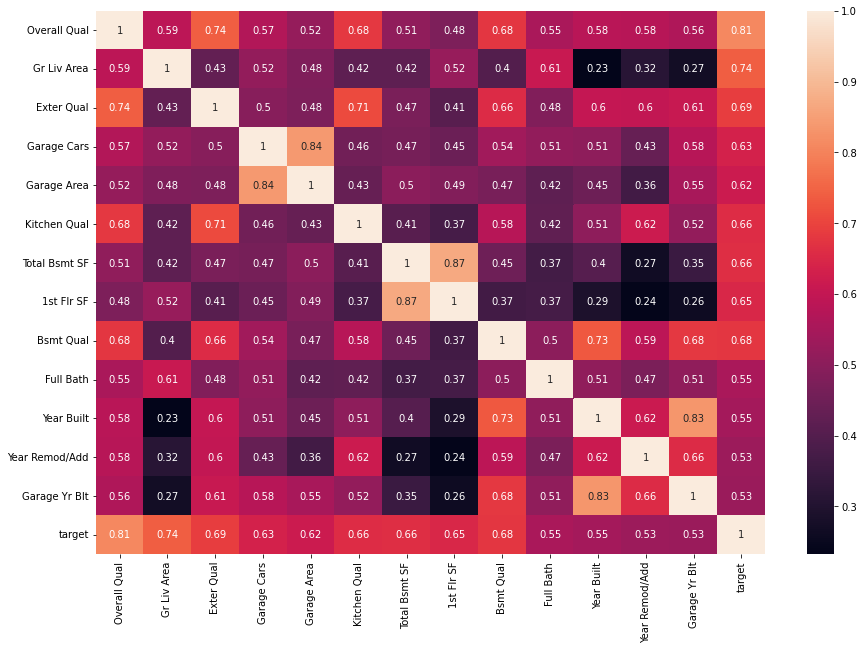

In [324]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(train_dataset.corr(), annot=True)
plt.show()

In [325]:
# train_dataset['SF']=(train_dataset['Total Bsmt SF']+train_dataset['1st Flr SF'])/2
# X_train=train_dataset.drop(['target','Garage Area','Total Bsmt SF','1st Flr SF','Garage Yr Blt'], axis=1)
# y_train=train_dataset['target']
# test_dataset['SF']=(test_dataset['Total Bsmt SF']+test_dataset['1st Flr SF'])/2
# X_test=test_dataset.drop(['Garage Area','Total Bsmt SF','1st Flr SF', 'Garage Yr Blt'], axis=1)


In [326]:
X_train=train_dataset.drop(['target'], axis=1)
y_train=train_dataset['target']
X_test=test_dataset

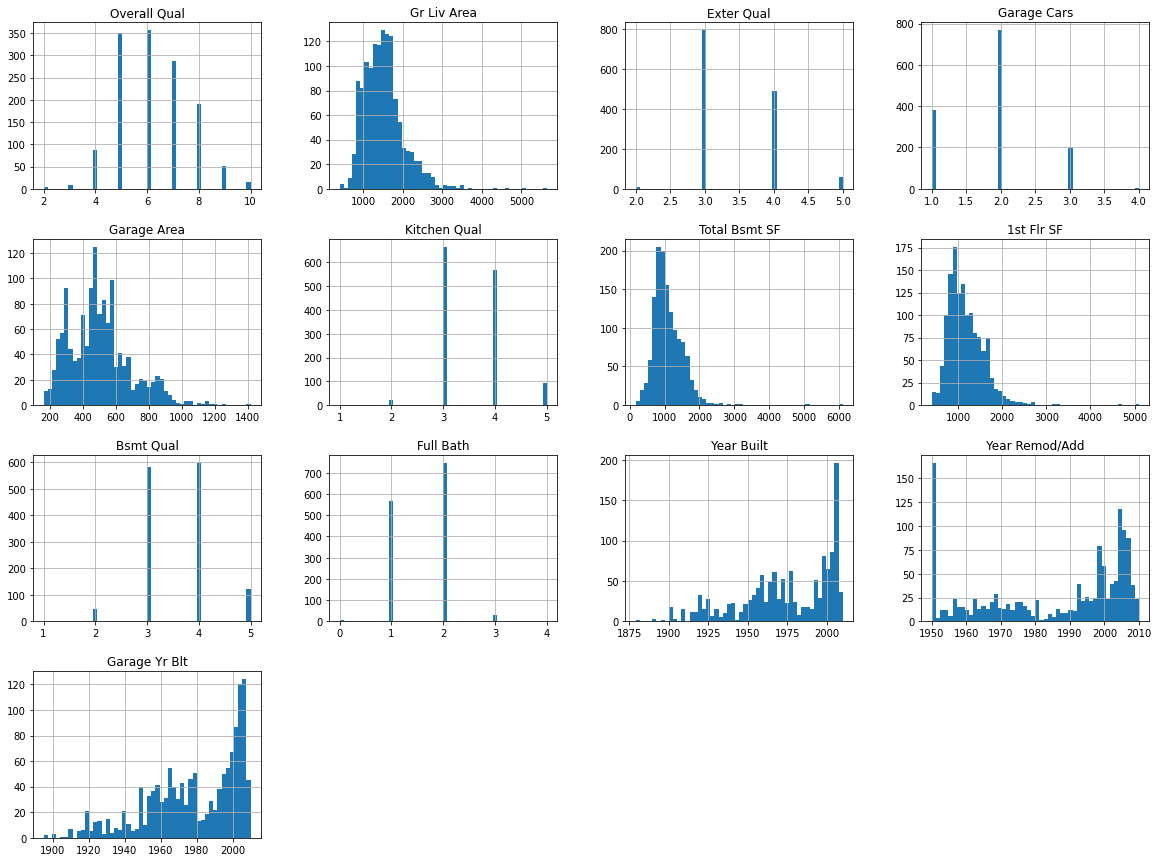

In [327]:
test_dataset.hist(bins=50, figsize=(20,15))
plt.show()

In [328]:
train_dataset['Built_Remod']=train_dataset['Year Remod/Add']-train_dataset['Year Built']
test_dataset['Built_Remod']=test_dataset['Year Remod/Add']-test_dataset['Year Built']

remod_train=train_dataset[(train_dataset['Year Remod/Add']!=1950)&(train_dataset['Year Built']>1950)]
remod_test=test_dataset[(test_dataset['Year Remod/Add']!=1950)&(test_dataset['Year Built']>1950)]

remod_X=remod_train.drop(['Built_Remod','target','Year Remod/Add'],axis=1)
remod_y=remod_train['Built_Remod']
remod_t=remod_test.drop(['Built_Remod','Year Remod/Add'],axis=1)

In [329]:
# #grid search
# param_grid={'max_depth':range(4,9),'n_estimators':range(100,1000,100)}
# from sklearn.model_selection import GridSearchCV
# grid_search=GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
# grid_search.fit(remod_X,remod_y)

# print("Best Parameter: {}".format(grid_search.best_params_))
# print("Best Score: {:.4f}".format(grid_search.best_score_))

In [330]:

from sklearn.ensemble import RandomForestRegressor
remod_model=RandomForestRegressor(max_depth=4, n_estimators=600)
remod_model.fit(remod_X,remod_y)
# print(remod_model.score(remod_X,remod_y))
# print(remod_model.score(remod_t,remod_test['Built_Remod']))

pred=remod_model.predict(remod_X)
pred=pd.DataFrame(pred)

Remod_features=['Overall Qual','Gr Liv Area','Exter Qual','Garage Cars','Garage Area','Kitchen Qual','Total Bsmt SF','1st Flr SF','Bsmt Qual','Full Bath','Year Built','Garage Yr Blt' ]

X_train['Year Remod/Add'].iloc[np.where(X_train['Year Remod/Add']==1950)] = X_train[X_train['Year Remod/Add']==1950]['Year Built'] + remod_model.predict(X_train[X_train['Year Remod/Add']==1950][Remod_features])
X_test['Year Remod/Add'].iloc[np.where(X_test['Year Remod/Add']==1950)] =X_test[X_test['Year Remod/Add']==1950]['Year Built'] + remod_model.predict(X_test[X_test['Year Remod/Add']==1950][Remod_features])

In [331]:
X_test=X_test.drop(['Built_Remod'],axis=1)

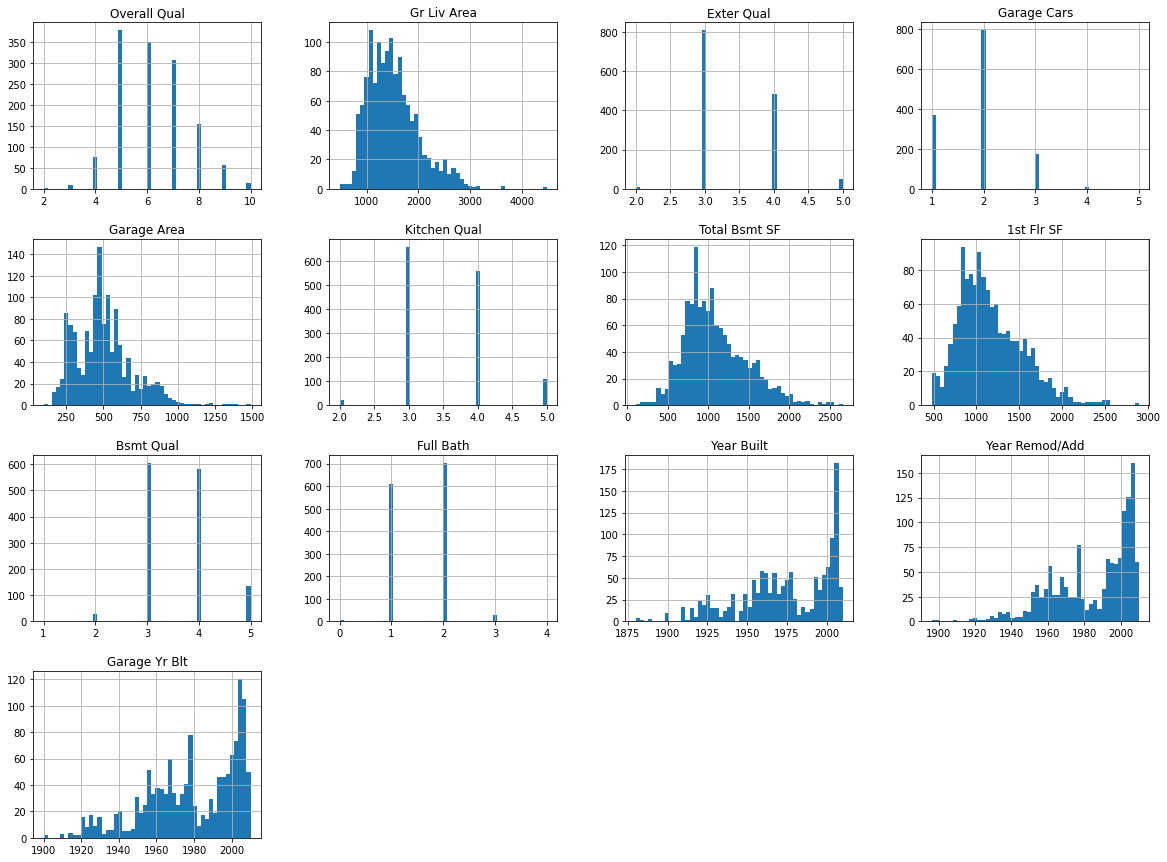

In [332]:
X_train=pd.DataFrame(X_train)
X_train.hist(bins=50, figsize=(20,15))
plt.show()

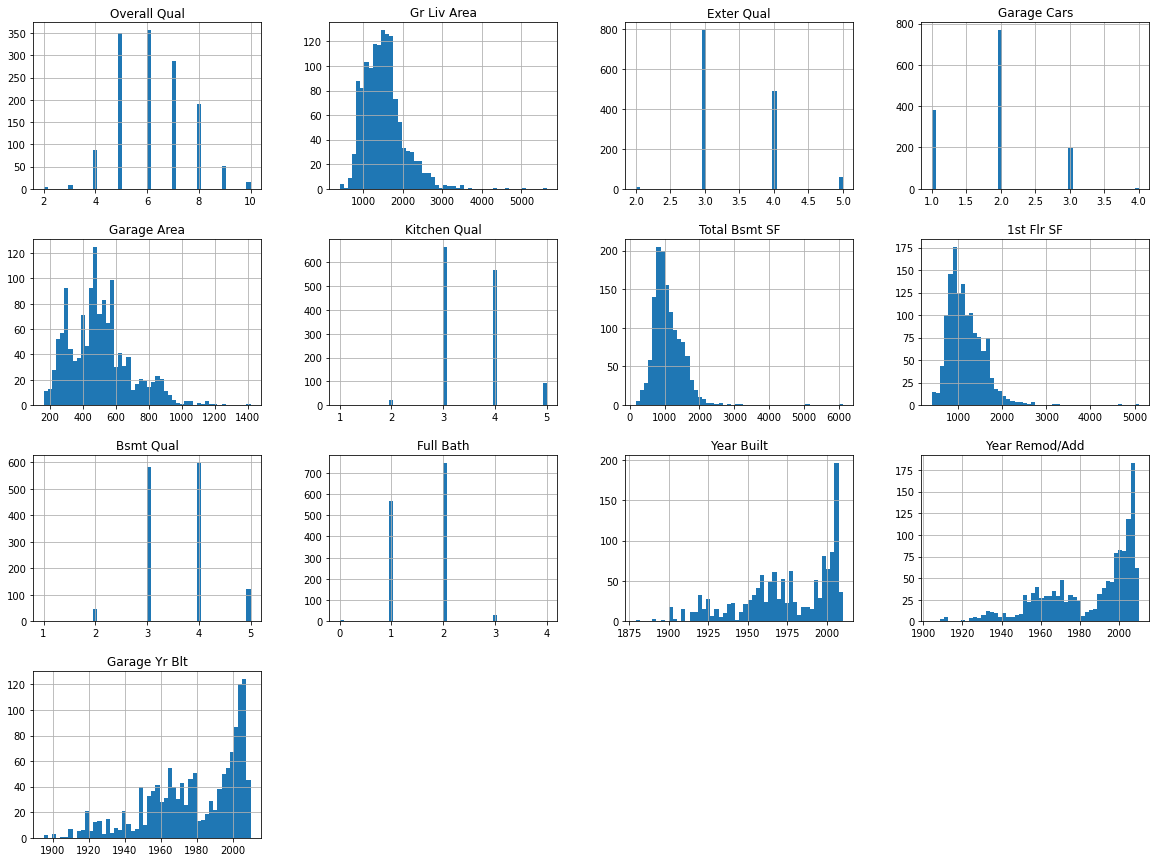

In [333]:
X_test.hist(bins=50, figsize=(20,15))
plt.show()

In [334]:
def logg(x) :
  for i in numeric_feature:
    x[i]=np.log1p(x[i])
  return x


X_train=logg(X_train)
X_test=logg(X_test)

In [335]:
 y_train=np.log1p(y_train)

In [336]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

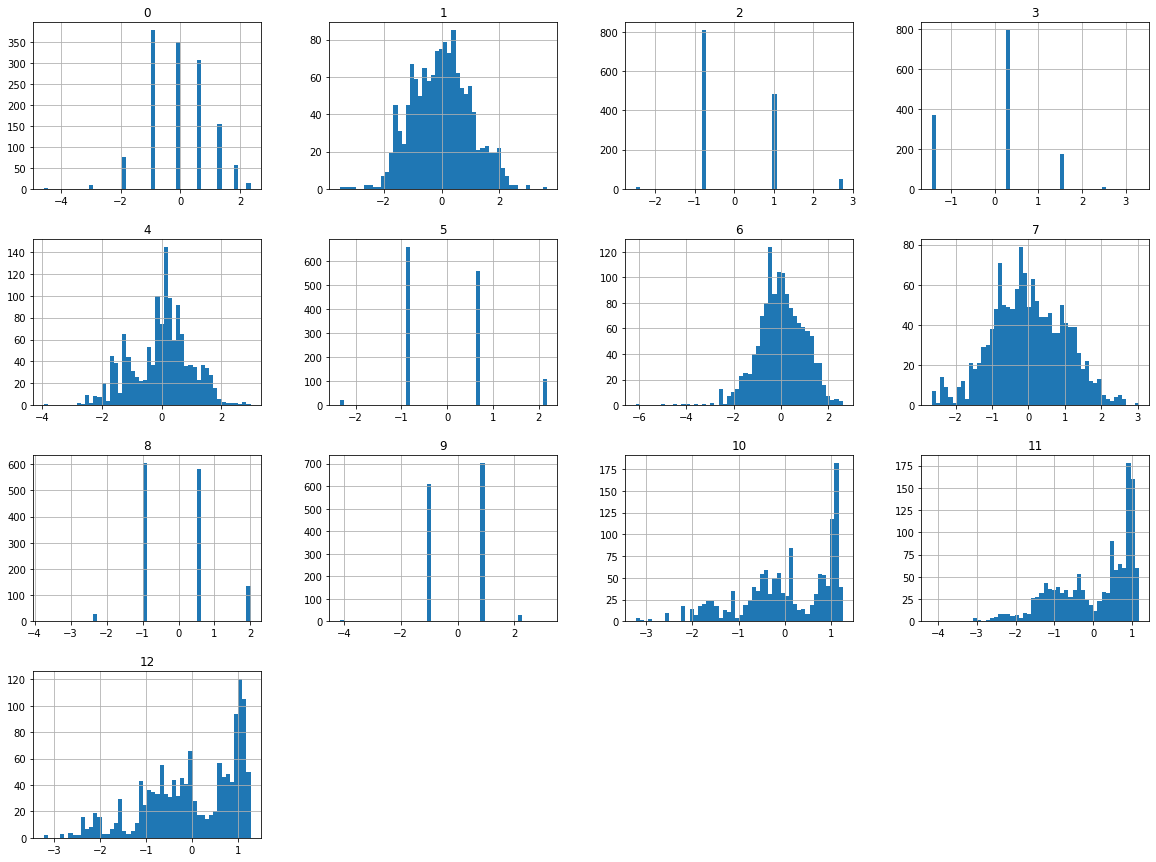

In [337]:
X_train=pd.DataFrame(X_train)
X_train.hist(bins=50, figsize=(20,15))
plt.show()

In [338]:
# NMAE 평가 함수 만들기
from sklearn.metrics import make_scorer

def NMAE(true, pred) -> float:
    mae = np.mean(np.abs(np.expm1(true) - np.expm1(pred)))
    score = mae / np.mean(np.abs(np.expm1(true)))
    return score

nmae_score = make_scorer(NMAE, greater_is_better=False)

In [339]:
scoring = 'nmae_score'

models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('EN',ElasticNet()))
models.append(('SVM',SVR()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGBR',XGBRegressor(max_depth=3,n_estimators=100,objective='reg:squarederror')))
models.append(('LGBMR',LGBMRegressor()))
models.append(('CatBR',CatBoostRegressor(max_depth=4, n_estimators=900, silent=True)))
models.append(('AdaR',AdaBoostRegressor()))
models.append(('Xtree',ExtraTreesRegressor(max_depth=8,n_estimators=900)))

results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold,scoring=nmae_score)
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,-cv_results.mean(),cv_results.std())
  print(msg)

LR : 0.100626 (0.005846) 
LASSO : 0.299776 (0.022133) 
KNN : 0.105907 (0.011011) 
CART : 0.137824 (0.007109) 
EN : 0.299776 (0.022133) 
SVM : 0.096705 (0.008491) 
RFR : 0.098457 (0.007743) 
XGBR : 0.096648 (0.005426) 
LGBMR : 0.099227 (0.008460) 
CatBR : 0.093896 (0.006424) 
AdaR : 0.121119 (0.010664) 
Xtree : 0.098217 (0.009919) 


In [340]:
X_test=pd.DataFrame(X_test)

In [341]:
# #grid search
# param_grid={'max_depth':range(3,9),'n_estimators':range(100,1000,100)}
# from sklearn.model_selection import GridSearchCV
# grid_search=GridSearchCV(ExtraTreesRegressor(), param_grid, cv=5)
# grid_search.fit(X_train,y_train)

# print("Best Parameter: {}".format(grid_search.best_params_))
# print("Best Score: {:.4f}".format(grid_search.best_score_))

In [342]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor()
model.fit(X_train,y_train)

model_cat=CatBoostRegressor(max_depth=4, n_estimators=900, silent=True)
model_cat.fit(X_train,y_train)

import lightgbm as lgb
from lightgbm import LGBMRegressor
model_lgb=LGBMRegressor()
model_lgb.fit(X_train,y_train)

import xgboost as xgb
from xgboost import XGBRegressor
model_xgb=XGBRegressor(max_depth=3,n_estimators=100, objective='reg:squarederror')
model_xgb.fit(X_train,y_train)

model_xt=ExtraTreesRegressor(max_depth=8,n_estimators=900)
model_xt.fit(X_train,y_train)

pred=model.predict(X_test)
pred2=model_cat.predict(X_test)
pred3=model_lgb.predict(X_test)
pred4=model_xgb.predict(X_test)
pred5=model_xt.predict(X_test)

# pred_fin=np.expm1(pred)
pred_fin=np.expm1(0.5*pred2+0.25*pred4+0.25*pred5)
pred_fin=pd.DataFrame(pred_fin).round(0)
pred_fin.columns=['target']

In [343]:
sub=pd.concat([test_id,pred_fin], axis=1)
sub.columns=['id','target']
print(sub)

sub.to_csv('01_29_hype_round_house.csv', index=False)

        id    target
0        1  331570.0
1        2  129726.0
2        3  180962.0
3        4  246493.0
4        5  133725.0
...    ...       ...
1345  1346  331393.0
1346  1347  125992.0
1347  1348   75480.0
1348  1349  187091.0
1349  1350  142237.0

[1350 rows x 2 columns]
